# Modelo de machine learning capaz de analisar uma planilha de usuários que solicitam empréstimos e avaliá-lo, de acordo com seus dados, se será um bom pagador ou não

# Contents  
**1 - Load data  
2 - Analysis  
3 - Pre-process  
4 - Modeling  
5 - Evaluate results**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 1 Load Data

In [2]:
loans = pd.read_csv('../data/loan_data.csv')
loans

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,all_other,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1
9574,0,all_other,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1
9575,0,debt_consolidation,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1
9576,0,home_improvement,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1


credit.policy: 1 se o cliente atender aos critérios de subscrição de crédito do LendingClub.com e 0 caso contrário.

purpose: a finalidade do empréstimo (assume os valores "cartão de crédito", "consolidação da dívida", "educacional", "compra principal", "empresa de pequeno porte" e "todos os outros").

int.rate: a taxa de juros do empréstimo, em proporção (uma taxa de 11% seria armazenada em 0,11). Os mutuários julgados pelo LendingClub.com como mais arriscados recebem taxas de juros mais altas.

installment: as parcelas mensais devidas pelo mutuário se o empréstimo for financiado.

log.annual.inc: o log natural da renda anual autorreferida do mutuário.

dti: O rácio dívida / rendimento do mutuário (montante da dívida dividido pelo rendimento anual).

fico: A pontuação de crédito FICO do mutuário.

days.with.cr.line: o número de dias em que o mutuário teve uma linha de crédito.

revol.bal: o saldo rotativo do mutuário (valor não pago no final do ciclo de cobrança do cartão de crédito).

revol.util: a taxa de utilização da linha rotativa do mutuário (o valor da linha de crédito usada em relação ao crédito total disponível).

inq.last.6mths: o número de consultas do mutuário pelos credores nos últimos 6 meses.

delinq.2yrs: o número de vezes que o mutuário estava com mais de 30 dias de atraso devido a um pagamento nos últimos 2 anos.

pub.rec: número de registros públicos depreciativos do tomador de crédito (pedidos de falência, penhoras fiscais ou julgamentos).

not.fully.paid - não totalmente pago


In [3]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [4]:
loans.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


# 2 Analysis

Text(0.5, 0, 'FICO')

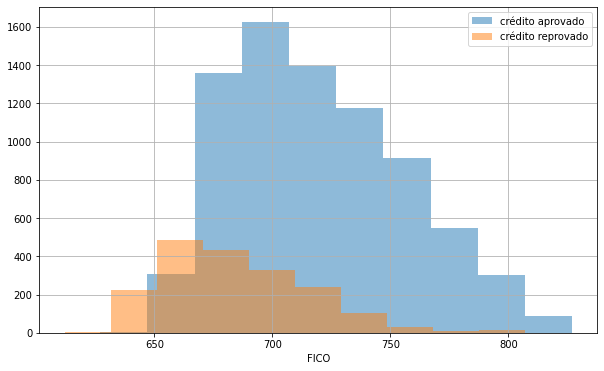

In [6]:
# pontuação fico é a pontuaçãode crédito de usuários 
# os usuários com crédito repŕovado normalmente tem menor pontuação fico
plt.figure(figsize=(10,6))
loans[loans['credit.policy']==1]['fico'].hist(alpha=0.5, label='crédito aprovado')
loans[loans['credit.policy']==0]['fico'].hist(alpha=0.5, label='crédito reprovado')
plt.legend()
plt.xlabel('FICO')

Text(0.5, 0, 'FICO')

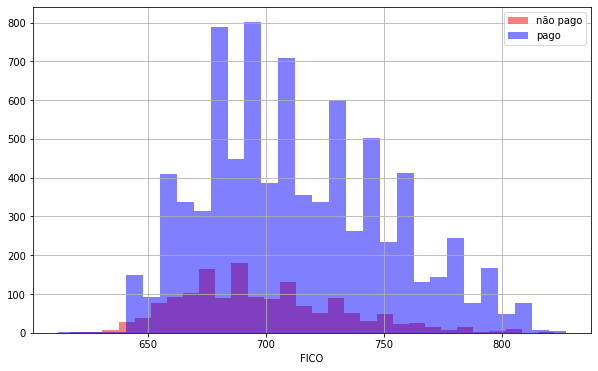

In [7]:
# pontuação fico de usuários X seu histórico de pagamento de emprestimo anterior
# os usuários que pagaram seus empréstimos anteriores normalmente tem maior pontuação fico
plt.figure(figsize=(10,6))
loans[loans['not.fully.paid']==1]['fico'].hist(alpha=0.5,color='red', label='não pago',bins=30)
loans[loans['not.fully.paid']==0]['fico'].hist(alpha=0.5,color='blue', label='pago', bins=30)
plt.legend()
plt.xlabel('FICO')

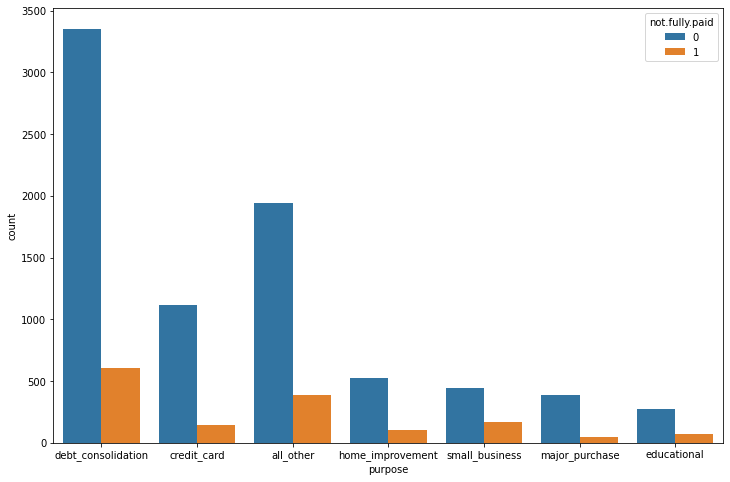

In [8]:
# Relação entre motivo de pedido de empréstimo e a quantidade de aprovações
# Empréstimo pago em azul e os que não pagaram em laranja
# a maioria dos motivos de pedido de empréstimo é para pagamento de dívidas

plt.figure(figsize=(12,8))
sns.countplot(data=loans, x='purpose', hue='not.fully.paid')

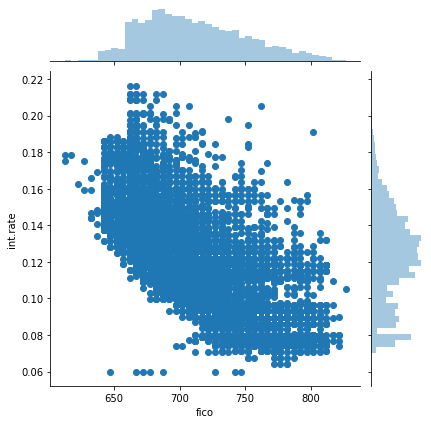

In [11]:
# análise de pontuação fico x taxa de juros, Juros é menor para usuários de maior pontuação
# e maior juros para usuários com menor pontuação
sns.jointplot(data=loans, x='fico', y='int.rate')

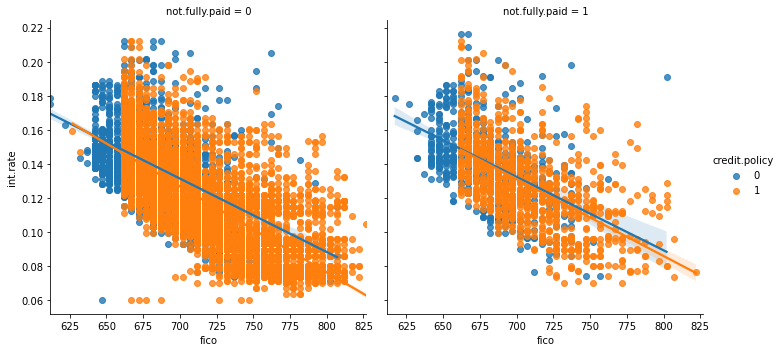

In [12]:
# pontuação fico x taxa de juros entre aceitação pela política de crédito
# clitnes que pagaram totalmente seu empréstimo anterior not.fully.paid = (0)
# Os juros sempre é menor para que tem crédito aprovado e para quem pagou seu último empréstimo
 
sns.lmplot(data=loans, x='fico', y='int.rate', hue='credit.policy', col='not.fully.paid')

# 3 Pre-process

In [13]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


PURPOSE, É UMA VARIÁVEL CATEGÓRICA, NECESSITA SER TRANSFORMADA EM NUMÉRICA PARA ENTRAR NO PROCESSO

In [3]:
cat_feats = ['purpose']

In [4]:
# cria uma coluna para cada variável de purpose e adiciona ao final da tabela loans
final_data = pd.get_dummies(loans,columns=cat_feats,drop_first=True)

In [5]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   credit.policy               9578 non-null   int64  
 1   int.rate                    9578 non-null   float64
 2   installment                 9578 non-null   float64
 3   log.annual.inc              9578 non-null   float64
 4   dti                         9578 non-null   float64
 5   fico                        9578 non-null   int64  
 6   days.with.cr.line           9578 non-null   float64
 7   revol.bal                   9578 non-null   int64  
 8   revol.util                  9578 non-null   float64
 9   inq.last.6mths              9578 non-null   int64  
 10  delinq.2yrs                 9578 non-null   int64  
 11  pub.rec                     9578 non-null   int64  
 12  not.fully.paid              9578 non-null   int64  
 13  purpose_credit_card         9578 

In [8]:
final_data

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1,0,0,0,0,0,0
9574,0,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1,0,0,0,0,0,0
9575,0,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1,0,1,0,0,0,0
9576,0,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1,0,0,0,1,0,0


credit.policy


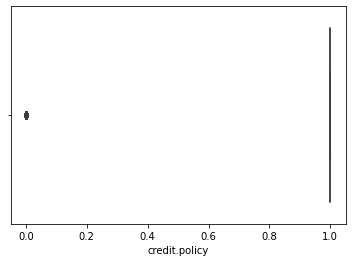

int.rate


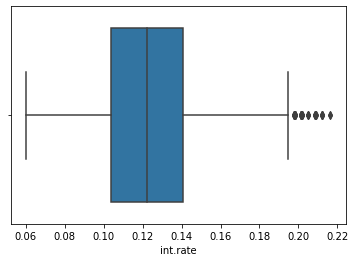

installment


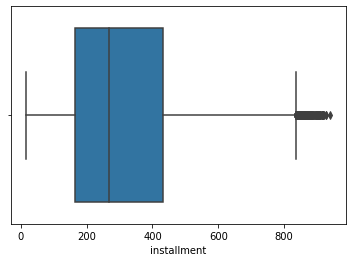

log.annual.inc


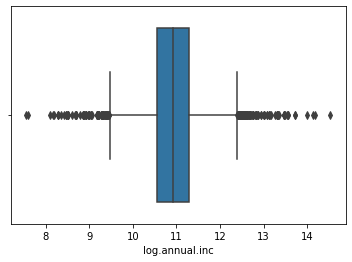

dti


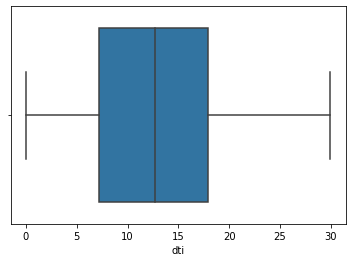

fico


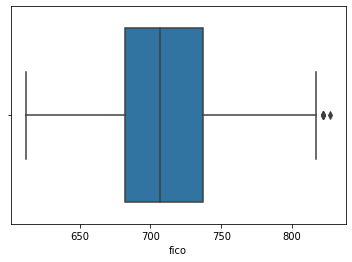

days.with.cr.line


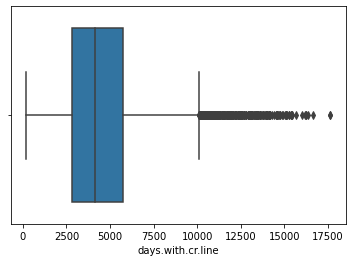

revol.bal


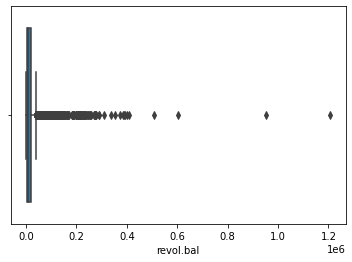

revol.util


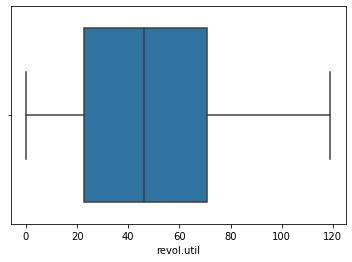

inq.last.6mths


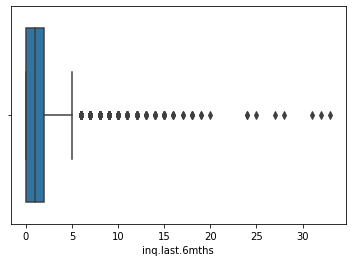

delinq.2yrs


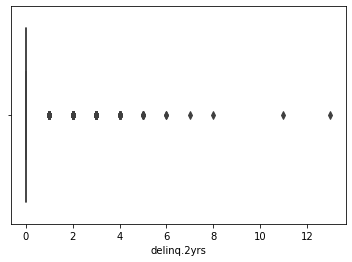

pub.rec


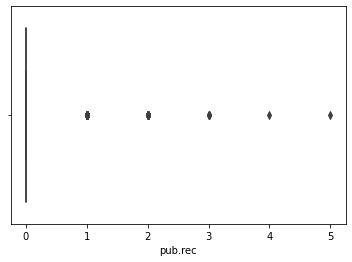

not.fully.paid


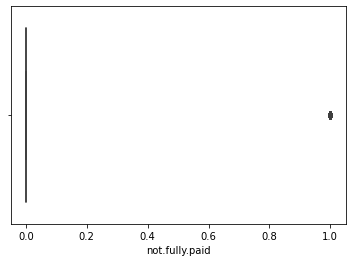

purpose_credit_card


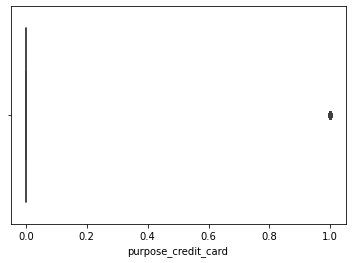

purpose_debt_consolidation


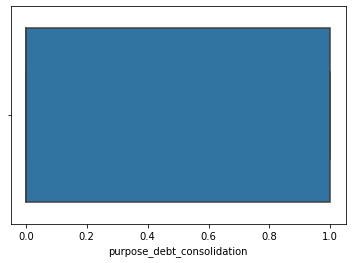

purpose_educational


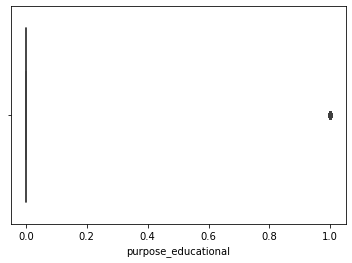

purpose_home_improvement


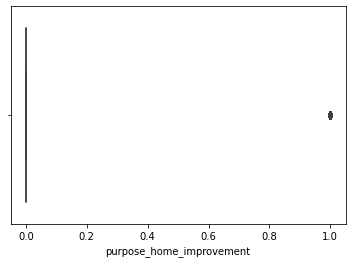

purpose_major_purchase


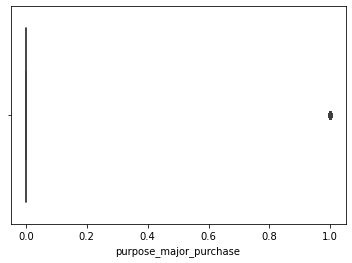

purpose_small_business


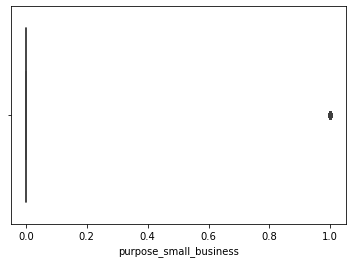

In [7]:
#  exploração de frequência de todos os dados para avaliação de outliers
for coluna in final_data:
    print(coluna)
    sns.boxplot(x=coluna, data =final_data)
    plt.show()

In [6]:
from Preprocess import Preprocess

In [7]:
#avaliando % de outliers e suas respectivas features
Preprocess().find_ouliers(final_data)

51 (0.53%) observações consideradas outlies da variável int.rate
236 (2.46%) observações consideradas outlies da variável installment
238 (2.48%) observações consideradas outlies da variável log.annual.inc
0 (2.48%) observações consideradas outlies da variável dti
6 (0.06%) observações consideradas outlies da variável fico
346 (3.61%) observações consideradas outlies da variável days.with.cr.line
780 (8.14%) observações consideradas outlies da variável revol.bal
0 (8.14%) observações consideradas outlies da variável revol.util
756 (7.89%) observações consideradas outlies da variável inq.last.6mths
0 (7.89%) observações consideradas outlies da variável purpose_debt_consolidation
No total, 2040 (21.3%) linhas são outliers, sendo 310 (3.24%) em pelo menos 1 variável(Retirando os duplicados)


In [8]:
# caso não seja problema a transformação ds outliers para as features acima, transformo-as
df_change_log = Preprocess().convert_to_log(final_data)

['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'purpose_debt_consolidation']


In [9]:
# avaliação de redução de outliers pós transformação de log, reduzindo 6% de outliers
Preprocess().find_ouliers(df_change_log)

51 (0.53%) observações consideradas outlies da variável int.rate
238 (2.48%) observações consideradas outlies da variável log.annual.inc
0 (2.48%) observações consideradas outlies da variável dti
0 (2.48%) observações consideradas outlies da variável revol.util
146 (1.52%) observações consideradas outlies da variável installment_log
0 (1.52%) observações consideradas outlies da variável fico_log
218 (2.28%) observações consideradas outlies da variável days.with.cr.line_log
598 (6.24%) observações consideradas outlies da variável revol.bal_log
478 (4.99%) observações consideradas outlies da variável inq.last.6mths_log
No total, 1452 (15.16%) linhas são outliers, sendo 238 (2.48%) em pelo menos 1 variável(Retirando os duplicados)


In [10]:
# apara todos outliers, necessário pré avaliação dos outliers antes desta transformação
df_quantil_change = Preprocess().cap_by_quantil(df_change_log)

['int.rate', 'log.annual.inc', 'dti', 'revol.util', 'installment_log', 'fico_log', 'days.with.cr.line_log', 'revol.bal_log', 'inq.last.6mths_log']


credit.policy


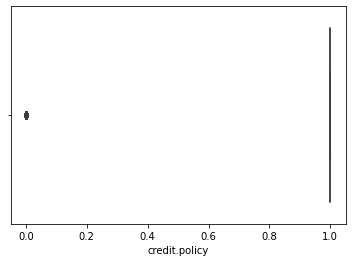

int.rate


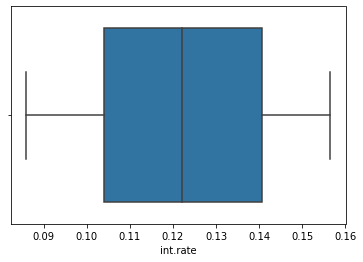

log.annual.inc


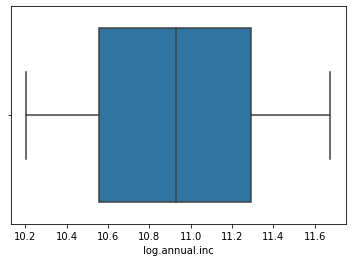

dti


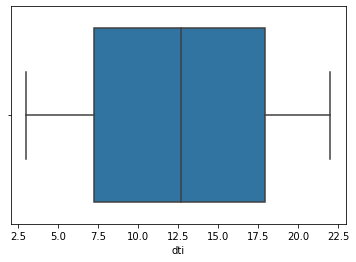

revol.util


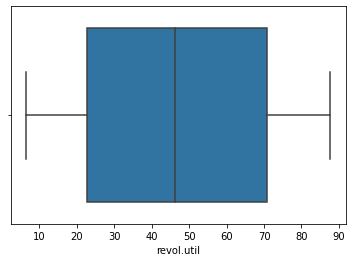

delinq.2yrs


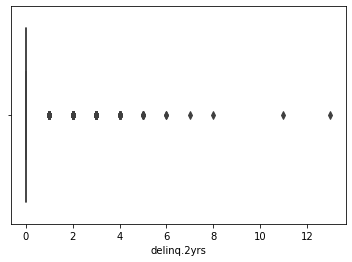

pub.rec


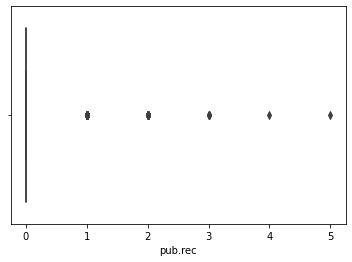

not.fully.paid


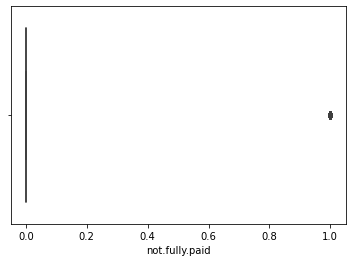

purpose_credit_card


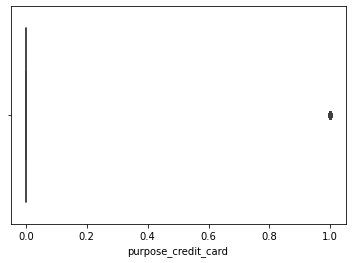

purpose_educational


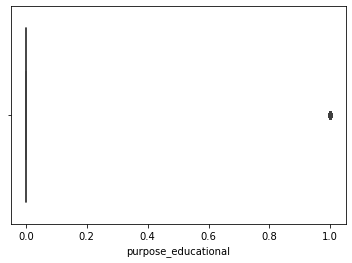

purpose_home_improvement


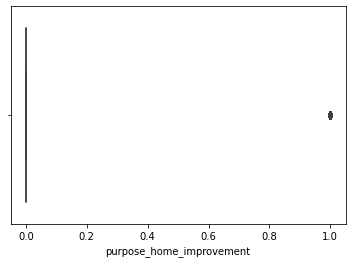

purpose_major_purchase


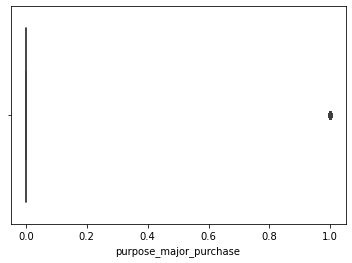

purpose_small_business


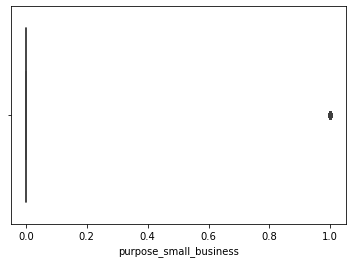

installment_log


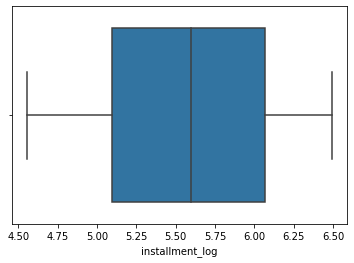

fico_log


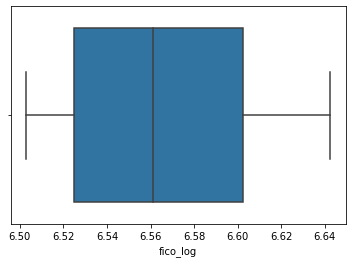

days.with.cr.line_log


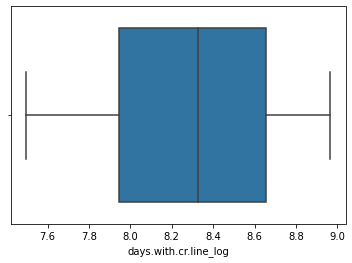

revol.bal_log


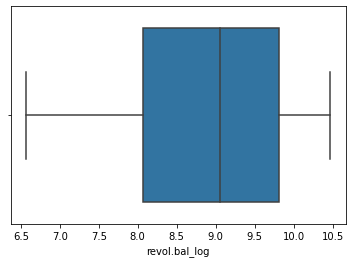

inq.last.6mths_log


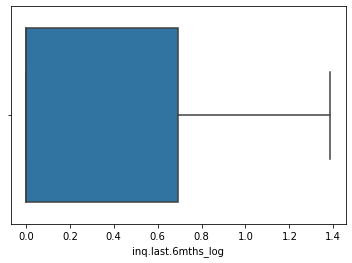

purpose_debt_consolidation_log


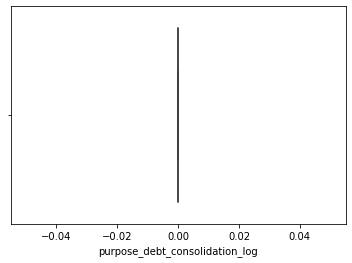

In [12]:
#  Sem outliers depois de aplicar cap_by_quantil
for coluna in df_quantil_change:
    print(coluna)
    sns.boxplot(x=coluna, data =df_quantil_change)
    plt.show()

credit.policy


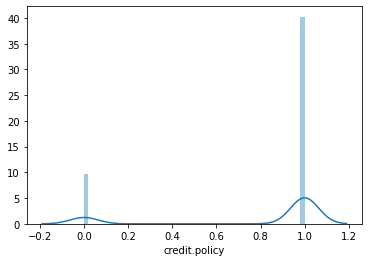

int.rate


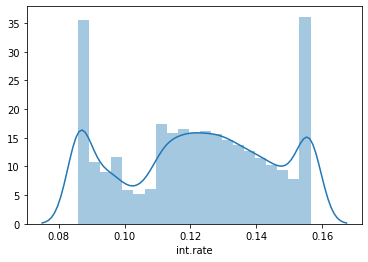

log.annual.inc


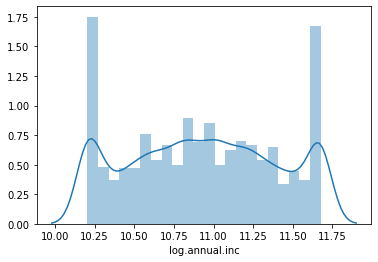

dti


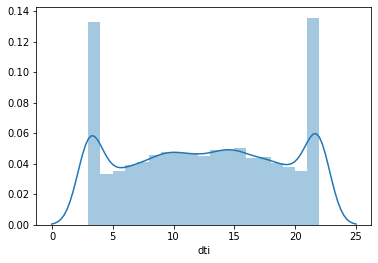

revol.util


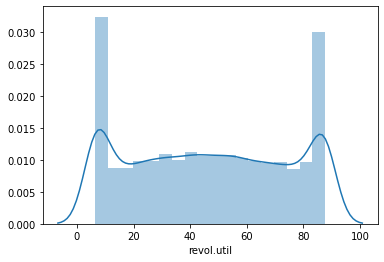

delinq.2yrs


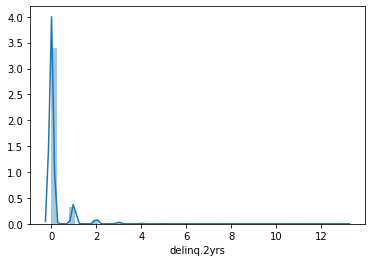

pub.rec


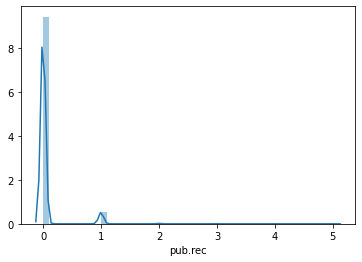

not.fully.paid


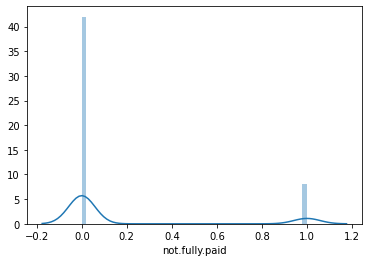

purpose_credit_card


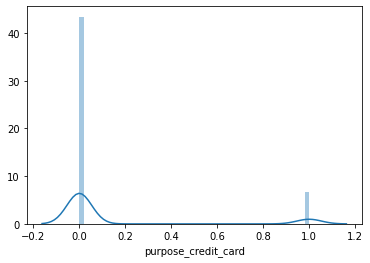

purpose_educational


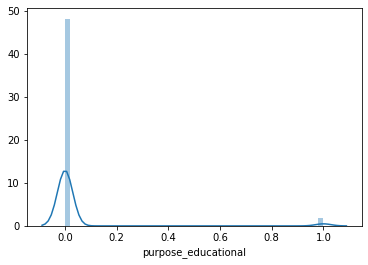

purpose_home_improvement


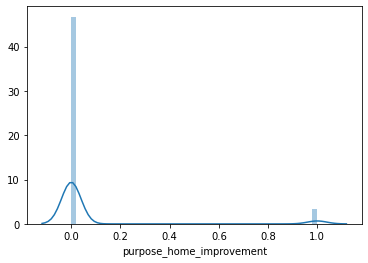

purpose_major_purchase


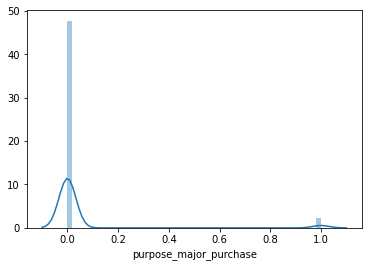

purpose_small_business


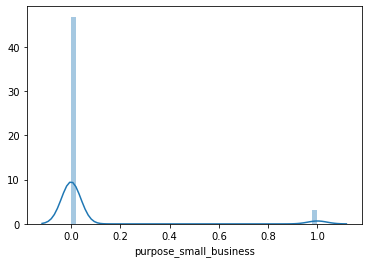

installment_log


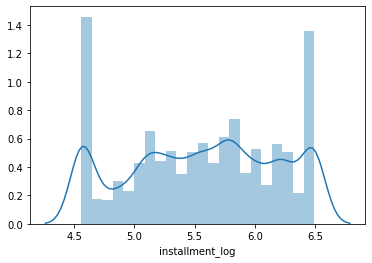

fico_log


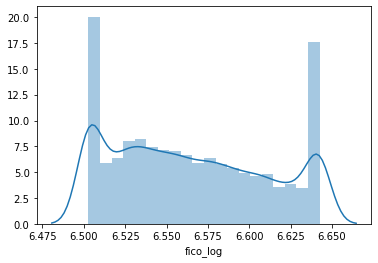

days.with.cr.line_log


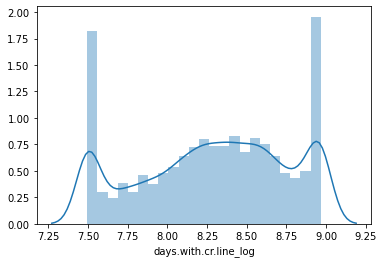

revol.bal_log


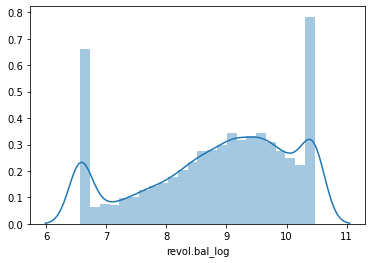

inq.last.6mths_log


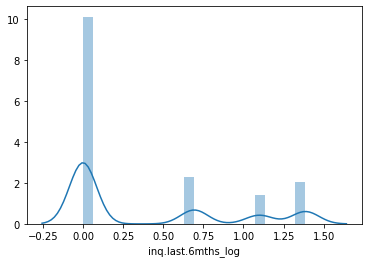

purpose_debt_consolidation_log


/home/lucas/.local/share/virtualenvs/Analise_de_credito-f8eAzfnM/lib/python3.6/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


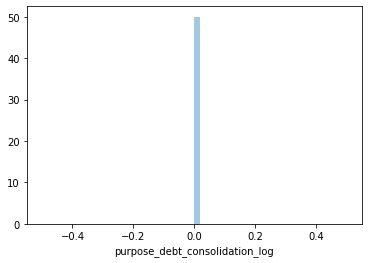

In [30]:
#  Avaliação da distribuição dos dados
for coluna in df_quantil_change:
    print(coluna)
    sns.distplot(df_quantil_change[coluna])
    plt.show()

# 3 Modeling
**Definindo Baseline**

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# train test: features serão todas as colunas e o alvo será a coluna not fully paid, não pagou totalmente o empréstimo anterior
X = final_data.drop('not.fully.paid',axis=1)
y = final_data['not.fully.paid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [13]:
from sklearn.tree import DecisionTreeClassifier

**MODELO DECISION OF TREE**

In [34]:
# model decision tree
dtree = DecisionTreeClassifier()

In [35]:
# train model
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [36]:
predictions = dtree.predict(X_test)

In [69]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

In [38]:
#  classificação do modelo decision of tree, baixa, tentar forest tree
print(confusion_matrix(y_test,predictions))

print(classification_report(y_test,predictions))


[[1997  434]
 [ 342  101]]
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      2431
           1       0.19      0.23      0.21       443

    accuracy                           0.73      2874
   macro avg       0.52      0.52      0.52      2874
weighted avg       0.75      0.73      0.74      2874



Accuracy 0.8465553235908142


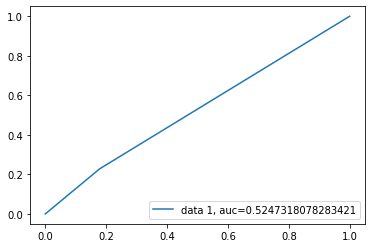

In [47]:
print("Accuracy", metrics.accuracy_score(y_test,predictions))
y_pred_proba = dtree.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [49]:
# resultaods muito ruins de AUC, mostrando que as predições estão quase aleatórias
#  modelo está acertando praticamente metade dos verdadeiros positivos
metrics.roc_auc_score(y_test, y_pred_proba)

0.5247318078283421

**Treinando modelo random forest**

In [70]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
#crinado mdoelo random forest
rfc = RandomForestClassifier(n_estimators=600)

In [52]:
# treinando
rfc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=600)

In [53]:
# previsão
predictions = rfc.predict(X_test)

In [54]:
#  classificação do modelo random forest, melhor que o decision of tree
print(confusion_matrix(y_test,predictions))

print(classification_report(y_test,predictions))

[[2423    8]
 [ 435    8]]
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2431
           1       0.50      0.02      0.03       443

    accuracy                           0.85      2874
   macro avg       0.67      0.51      0.48      2874
weighted avg       0.79      0.85      0.78      2874



Accuracy 0.8458594293667363


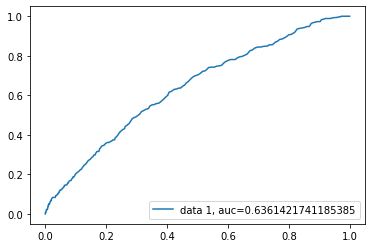

In [55]:
print("Accuracy", metrics.accuracy_score(y_test,predictions))
y_pred_proba = rfc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [56]:
# resultaods melhorando um pouco em relação a AUC com random forest, será utilizado como baseline
metrics.roc_auc_score(y_test, y_pred_proba)

0.6361421741185385

**Testando baseline com feaures transformadas em log e sem outliers, quantil aparado**

In [14]:
# train test: features serão todas as colunas e o alvo será a coluna not fully paid, não pagou totalmente o empréstimo anterior
X = df_quantil_change.drop('not.fully.paid',axis=1)
y = df_quantil_change['not.fully.paid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [23]:
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)

#  classificação do modelo random forest, melhor que o decision of tree
print(confusion_matrix(y_test,predictions))

print(classification_report(y_test,predictions))

[[2427    4]
 [ 435    8]]
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2431
           1       0.67      0.02      0.04       443

    accuracy                           0.85      2874
   macro avg       0.76      0.51      0.48      2874
weighted avg       0.82      0.85      0.78      2874



uma breve melhora na precisão de acerto dos verdadeiros positivos utilizando as
features transformadas de 50% para 67%

Accuracy 0.8472512178148921


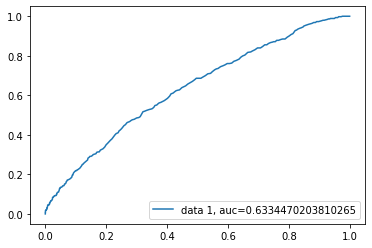

In [24]:
print("Accuracy", metrics.accuracy_score(y_test,predictions))
y_pred_proba = rfc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [47]:
# resultaods melhorando um pouco em relação a AUC com random forest, será utilizado como baseline
metrics.roc_auc_score(y_test, y_pred_proba)

0.6352804677728326

**Seleção de modelos pela curva AUC**

In [27]:
from model_test import Model_select

In [28]:
# teste de diversos hiperparâmetros entre diversos modelos para classificação por AUC
Model_select().testing_hip_par(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   20.3s finished


--------------------------------------------------------------------
Random Forest
Best Score: 0.66
Best Params: {'criterion': 'gini', 'n_estimators': 300}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


--------------------------------------------------------------------
Logistic Regression
Best Score: 0.67
Best Params: {'C': 1, 'penalty': 'l2'}
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   35.5s finished


--------------------------------------------------------------------
Extra tree classifier
Best Score: 0.65
Best Params: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 200}
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


--------------------------------------------------------------------
Knn
Best Score: 0.56
Best Params: {'algorithm': 'auto', 'n_neighbors': 20, 'weights': 'distance'}
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  13 out of  20 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


--------------------------------------------------------------------
Decision of Tree
Best Score: 0.55
Best Params: {'criterion': 'gini', 'splitter': 'best'}
Fitting 5 folds for each of 196 candidates, totalling 980 fits


[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 498 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 980 out of 980 | elapsed:  1.9min finished


--------------------------------------------------------------------
bagging_dec_tree
Best Score: 0.67
Best Params: {'max_features': 7, 'max_samples': 200, 'n_estimators': 500}
Fitting 5 folds for each of 196 candidates, totalling 980 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 66.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 120.8min
[Parallel(n_jobs=-1)]: Done 980 out of 980 | elapsed: 154.3min finished


--------------------------------------------------------------------
bagging_RFC
Best Score: 0.67
Best Params: {'max_features': 5, 'max_samples': 200, 'n_estimators': 500}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.0min finished


--------------------------------------------------------------------
SVC
Best Score: 0.59
Best Params: {'C': 10, 'gamma': 'auto'}
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


--------------------------------------------------------------------
GNB NAIVE BAYES
Best Score: 0.66
Best Params: {'var_smoothing': 1e-09}


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.3s finished


**Após o teste de hiperparâmetros o modelo de Baggings para random forest foi o que obteve melhores resultados, subindo o valor de auc de 63 para 68, sendo que além dos bons resultaods AUC é o tipo de modelo que faz sentido para este tipo de problema de classificação, com isso avançou-se para avaliá-lo melhor**

**Seleção de variáveis e avaliação de seu nível de importância**

In [82]:
from Feat_select import Feat_select

In [75]:
# mostra um rank de importância das features
lista_features = Feat_select().rank(X,y)

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 50building tree 2 of 50

building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.4s


building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.7s finished
/home/lucas/.local/share/virtualenvs/Analise_de_credito-f8eAzfnM/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


                          features  RF rank        RFR  linreg  logreg   etc  \
12                 installment_log        1  11.877584    0.39       7  10.6   
3                              dti        2  12.020903   -0.00      15  10.6   
15                   revol.bal_log        3  12.032713   -0.02      11  10.4   
14           days.with.cr.line_log        4  12.086527    0.24      12  10.7   
4                       revol.util        5  11.980328    0.00      13  10.8   
1                         int.rate        6  10.457895    2.81       1  10.7   
2                   log.annual.inc        7  10.913364   -0.56       6  10.6   
13                        fico_log        8   6.852796   -7.39       9   9.5   
16              inq.last.6mths_log        9   2.816206    0.45       5   4.1   
5                      delinq.2yrs       10   1.484669   -0.14      14   2.9   
0                    credit.policy       11   2.353970   -0.86       1   2.0   
11          purpose_small_business      

/home/lucas/.local/share/virtualenvs/Analise_de_credito-f8eAzfnM/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [17] are constant.
  UserWarning)
/home/lucas/.local/share/virtualenvs/Analise_de_credito-f8eAzfnM/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [30]:
lista_features

[['installment_log', 'dti'],
 ['installment_log', 'dti', 'revol.bal_log'],
 ['installment_log', 'dti', 'revol.bal_log', 'days.with.cr.line_log'],
 ['installment_log',
  'dti',
  'revol.bal_log',
  'days.with.cr.line_log',
  'revol.util'],
 ['installment_log',
  'dti',
  'revol.bal_log',
  'days.with.cr.line_log',
  'revol.util',
  'int.rate'],
 ['installment_log',
  'dti',
  'revol.bal_log',
  'days.with.cr.line_log',
  'revol.util',
  'int.rate',
  'log.annual.inc'],
 ['installment_log',
  'dti',
  'revol.bal_log',
  'days.with.cr.line_log',
  'revol.util',
  'int.rate',
  'log.annual.inc',
  'fico_log'],
 ['installment_log',
  'dti',
  'revol.bal_log',
  'days.with.cr.line_log',
  'revol.util',
  'int.rate',
  'log.annual.inc',
  'fico_log',
  'inq.last.6mths_log'],
 ['installment_log',
  'dti',
  'revol.bal_log',
  'days.with.cr.line_log',
  'revol.util',
  'int.rate',
  'log.annual.inc',
  'fico_log',
  'inq.last.6mths_log',
  'credit.policy'],
 ['installment_log',
  'dti',
  'revo

**Teste de combinações de features por valor de AUC**

In [83]:
# testa combinações de features e seus resultados de AUC
Feat_select().test_feat(lista_features, df_quantil_change)

['AUC :0.53- comb feat :0']
--------------------------------------------------------------------------------
['AUC :0.53- comb feat :1']
--------------------------------------------------------------------------------
['AUC :0.54- comb feat :2']
--------------------------------------------------------------------------------
['AUC :0.57- comb feat :3']
--------------------------------------------------------------------------------
['AUC :0.6- comb feat :4']
--------------------------------------------------------------------------------
['AUC :0.62- comb feat :5']
--------------------------------------------------------------------------------
['AUC :0.63- comb feat :6']
--------------------------------------------------------------------------------
['AUC :0.64- comb feat :7']
--------------------------------------------------------------------------------
['AUC :0.64- comb feat :8']
--------------------------------------------------------------------------------
['AUC :0.64- comb fe

**Seleção de features não aumentou o valor de AUC do modelo, com isso o modelo rodará com todas as features**

# 5 Evaluate results

Accuracy 0.8458594293667363


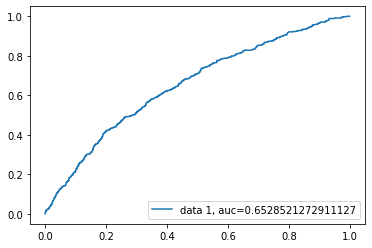

AUC:  0.6528521272911127


In [48]:
bagging_dec_tree = BaggingClassifier(DecisionTreeClassifier(),max_features = 7, max_samples=200, n_estimators=300,  bootstrap=True)
bagging_dec_tree.fit(X_train,y_train)
predictions = bagging_dec_tree.predict(X_test)

print("Accuracy", metrics.accuracy_score(y_test,predictions))
y_pred_proba = bagging_dec_tree.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

print('AUC: ', auc)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

In [49]:
#  classificação do modelo random forest, melhor que o decision of tree
print(confusion_matrix(y_test,predictions))

print(classification_report(y_test,predictions))

[[2431    0]
 [ 443    0]]
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2431
           1       0.00      0.00      0.00       443

    accuracy                           0.85      2874
   macro avg       0.42      0.50      0.46      2874
weighted avg       0.72      0.85      0.78      2874



/home/lucas/.local/share/virtualenvs/Analise_de_credito-f8eAzfnM/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Apesar de melhor resultado AUC o modelo de bagging piorou o resultaod de precisão do resultado 1(que é a precisão de acerto dos verdadeiros positivos, ficando em 0% de acerto de previsão dos usuários com crédito negado) o que vai na contramão do objetivo do modelo, que é prever justamente os usuários que deverão ter o crédito negado.  
Então decidiu-se retornar o modelo de Random Forest que, apesar de um pouco menor resultado de AUC, mantém uma precisão de 62% de acerto de usuários com crédito negado)**

In [50]:
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)

#  classificação do modelo random forest, melhor que o decision of tree
print(confusion_matrix(y_test,predictions))

print(classification_report(y_test,predictions))

[[2425    6]
 [ 433   10]]
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2431
           1       0.62      0.02      0.04       443

    accuracy                           0.85      2874
   macro avg       0.74      0.51      0.48      2874
weighted avg       0.81      0.85      0.78      2874



Accuracy 0.8472512178148921


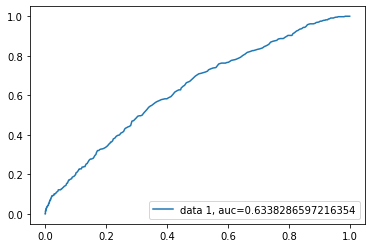

In [51]:
print("Accuracy", metrics.accuracy_score(y_test,predictions))
y_pred_proba = rfc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

**Os resultaods de AUC podem ser melhorados através de rebalanceamento das variáveis, visto que a quantidade de dados de usuários com crédito aprovado é muito maior do que a de usuários com crédito negado, o que influencia a qualidade dos resultados. Com isso, apartir daqui, é preciso checar se há a possibilidade de conseguir mais dados de usuários que tiveram seu pedido de crédito negado para melhorar a qualidade do modelo**